In [4]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import norm, chi2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

ro1=0.64
ro2=0.36

def CsI_wheight_tot(t, tau1, tau2, QR, RC):                     #funzione di fit per csi con pesi knoll, fit totale
    return QR/(ro1*tau1+ro2*tau2)*(ro1*np.exp(-t/tau1)+ro2*np.exp(-t/tau2)-np.exp(-t/(RC)))

def CsI_tot(t, tau, QR, RC):        #funzione  csi, fit totale
    return QR/tau*(np.exp(-t/tau)-np.exp(-t/(RC)))

#media pesata sugli errori

def w_mean(x,dx):
    return np.sum(x/dx**2)/np.sum(1/dx**2), np.sqrt(1/np.sum(1/dx**2))

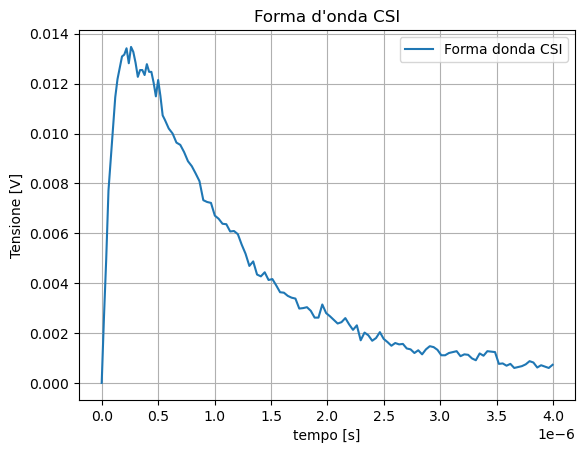

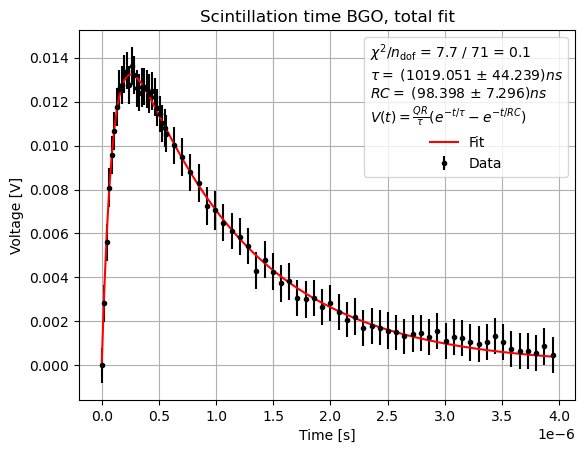

In [5]:
taus = np.zeros(7)
err_taus = np.zeros(7)
RCs = np.zeros(7)
err_RCs = np.zeros(7)
QRs = np.zeros(7)
err_QRs = np.zeros(7)

plt.plot(time, volt, label='Forma donda CSI')
plt.xlabel('tempo [s]')
plt.ylabel('Tensione [V]')
plt.title('Forma d\'onda CSI') 
plt.legend()
plt.grid()
plt.show()


for i in range(0,7):
#FIT FORMA D'ONDA CSI

    data = pd.read_csv('Forma-CSI.csv', delimiter=',')
    data1= pd.read_csv('CSI-Salita.csv', delimiter=',')
    data2= pd.read_csv('CSI-Discesa.csv', delimiter=',')

    smooth1=5+i
    smooth2=30+i

    times=np.array(data1['Time']+5e-08)[::smooth1]
    timed=np.array(data2['Time']+5e-08)[::smooth2]
    volts = np.array(data1['Voltage']-0.0004363636363636363)[::smooth1]
    voltd = np.array(data2['Voltage']-0.0004363636363636363)[::smooth2]
    time = np.concatenate((times,timed))    
    volt = np.concatenate((volts,voltd))

    #smoothing della forma d'onda

    #err sist sensibilità oscilloscopio
    err_volt_s = np.array(data1['error'])[::smooth1]
    err_volt_d = np.array(data2['error'])[::smooth2]
    err_volt = np.sqrt((np.concatenate((err_volt_s,err_volt_d))/np.sqrt(11))**2+(0.0008)**2)

 


    # fit CsI  non pesato totale

    ls = LeastSquares(time, volt, err_volt, CsI_tot)
    m1 = Minuit(ls, tau=1e-6, QR=10000, RC=0.8e-7)
    m1.migrad()
    m1.hesse()

    taus[i]=m1.values[0]
    err_taus[i]=m1.errors[0]
    QRs[i]=m1.values[1]
    err_QRs[i]=m1.errors[1]
    RCs[i]=m1.values[2]
    err_RCs[i]=m1.errors[2]
    
#trasformo in array np

taus=np.array(taus)
err_taus=np.array(err_taus)
QRs=np.array(QRs)
err_QRs=np.array(err_QRs)
RCs=np.array(RCs)
err_RCs=np.array(err_RCs)


plt.errorbar(time, volt, yerr=err_volt, fmt='.', label='Data', color='black')
plt.plot(time, CsI_tot(time, *m1.values), label='Fit', color='red')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.title('Scintillation time BGO, total fit')
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m1.fval:.1f} / {m1.ndof:.0f} = {(m1.fval/m1.ndof):.1f}",]
p_value = (1. - chi2.cdf(m1.fval, df=m1.ndof))
fit_info.append(f'$\\tau = $ ({m1.values[0]*1000000000:.3f} $\\pm$ {m1.errors[0]*1000000000:.3f})' + '$ns$')
fit_info.append(f'$RC = $ ({m1.values[2]*1000000000:.3f} $\\pm$ {m1.errors[2]*1000000000:.3f})' + '$ns$')
fit_info.append('$V(t) = \\frac{QR}{\\tau}(e^{-t/\\tau}-e^{-t/RC})$')
plt.legend(title="\n".join(fit_info), frameon=True)

plt.grid()
plt.show()


tau = 1.0285219946304823e-06 +/- 1.7863361012409236e-08
RC = 9.7446523265671e-08 +/- 2.328965264155109e-09


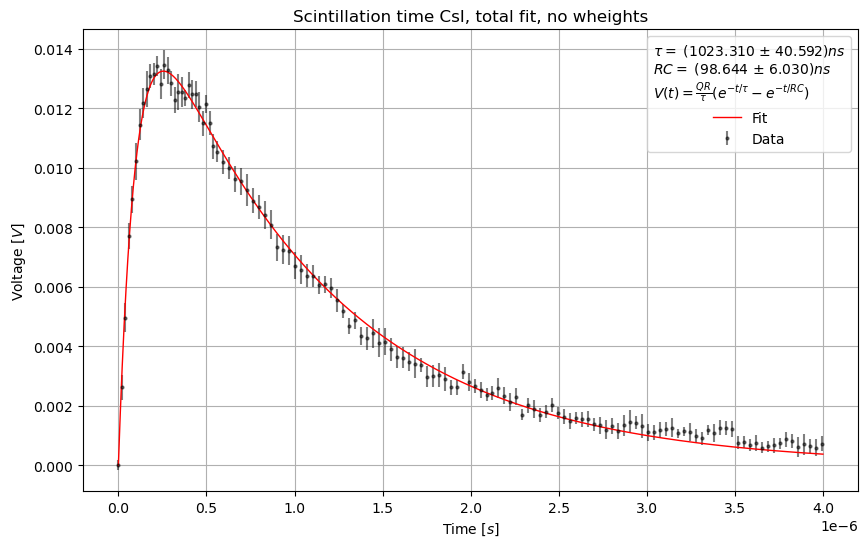

In [6]:

#plot finale

smooth1=10
smooth2=17

times=np.array(data1['Time']+5e-08)[::smooth1]
timed=np.array(data2['Time']+5e-08)[::smooth2]
volts = np.array(data1['Voltage']-0.0004363636363636363)[::smooth1]
voltd = np.array(data2['Voltage']-0.0004363636363636363)[::smooth2]
time = np.concatenate((times,timed))    
volt = np.concatenate((volts,voltd))

#smoothing della forma d'onda

#err sist sensibilità oscilloscopio
err_volt_s = np.array(data1['error'])[::smooth1]
err_volt_d = np.array(data2['error'])[::smooth2]
err_volt = np.sqrt((np.concatenate((err_volt_s,err_volt_d))/np.sqrt(6))**2+(0.00012)**2)

#media pesata
tau_mean, err_tau_mean = w_mean(taus,err_taus)
RCs_mean, err_RCs_mean = w_mean(RCs,err_RCs)
QRs_mean, err_QRs_mean = w_mean(QRs,err_QRs)
tot_err = np.sqrt(err_tau_mean**2+((np.max(taus)-np.min(taus))/2)**2)

print(f"tau = {tau_mean} +/- {tot_err}")
print(f"RC = {RCs_mean} +/- {err_RCs_mean}")
#plot di uno dei fit

x_axis = np.linspace(0, 4e-6, 10000)
y = CsI_tot(x_axis, taus[2], QRs[2], RCs[2])
plt.subplots(figsize=(10, 6))
plt.errorbar(time, volt, err_volt, fmt='o', label='Data', markersize=2, alpha=0.5, color='black')
plt.plot(x_axis, y, color='red', label='Fit', linewidth=1)
fit_info = []
fit_info.append(f'$\\tau = $ ({taus[2]*1000000000:.3f} $\\pm$ {err_taus[2]*1000000000:.3f})' + '$ns$')
fit_info.append(f'$RC = $ ({RCs[2]*1000000000:.3f} $\\pm$ {err_RCs[2]*1000000000:.3f})' + '$ns$')
fit_info.append('$V(t) = \\frac{QR}{\\tau}(e^{-t/\\tau}-e^{-t/RC})$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.title('Scintillation time CsI, total fit, no wheights')
plt.grid(True)
plt.xlabel('Time $[s]$')
plt.ylabel('Voltage $[V]$')
plt.show()


